# Проект осенней практики 01.09.23 - 28.09.23, СКБ МО РФ г.Краснодар
## Тема: Нейросетевой трекер объектов на основе архитектуры детектора YOLOv8
## Цель: изучение и детектора YOLOv8, а также осуществление трекинга объектов с помощью данного детектора и трекеров: ByteTrack, BoT-SORT, StrongSORT, OC-SORT. Для данной задачи с помощью инструмента-аннотатора CIVAT.ai был собран и размечен собственный датасет, на котором была обучена YOLOv8. Затем применялись перечисленные выше трекеры и подсчитывались метрики. Содержание датасета не разглашается.

# 1. Получение неразмеченных изображений из видеороликов #

### В изначальном предоставленном датасете мало изображений, все они слишком похожи и имеют плохую разметку, поэтому начнём сбор нового датасета. Извлечём неразмеченные изображения из некоторой подборки видеороликов, которую мы предварительно загрузили. Затем воспользуемся библиотекой opencv и будем с определенным периодом извлекать кадры из видео. Полученные изображения будут иметь название видеоролика, из которого они взяты, с указанием номера кадра. Данные действия относятся к сбору и предобработке датасета, поэтому скрипты, которые были для этого использованы, будут прикреплены к проекту отдельными файлами.

# Описание датасета


### Датасет содержит 634 обучающих изображения разного размера, размеченных на 8 классов.

###Augmentations:
  - RandomRotate(degrees=10)
  - RandomTranslate()
  - RandomScale()
  - RandomShift()
  - RandomFlip()
  - RandomNoise()



# 2. Обучение детектора YOLOv8 medium(Transfer learning, 100 эпох)

### Воспользуемся предобученной medium версией YOLOv8. Заморозим первые 10 слоёв и произведём обучение модели в течение 100 эпох.

In [2]:
from dataclasses import dataclass, field

In [3]:
@dataclass()
class DataPaths:
    dataset_gdrive_path: str = field(default="/content/drive/MyDrive/Datasets/object_tracking/dataset.zip")
    dataset_unzip_path: str = field(default='/content/datasets')
    test_video_path: str = field(default="/content/drive/MyDrive/Datasets/object_tracking/test-video.zip")

In [4]:
@dataclass()
class TrainingParams:
    pretrained_models_weight: str = field(default='yolov8m.pt')
    dataset_yaml_config: str = field(default='/content/datasets/dataset/data.yaml')
    image_size: int = field(default=640)
    epochs: int = field(default=100)
    batch_size: int = field(default=8)
    num_frozen_layers: int = field(default=10)
    result_dir: str = field(default='detection_yolo8m_100epochs')

In [9]:
data_paths = DataPaths()

In [10]:
training_params = TrainingParams()

In [ ]:
!pip install ultralytics --quiet
!mkdir /content/datasets
!unzip $data_paths.dataset_gdrive_path -d $data_paths.dataset_unzip_path

In [ ]:
from ultralytics import YOLO


pretrained_detect_model = YOLO(training_params.pretrained_models_weight)

results = pretrained_detect_model.train(
   data=training_params.dataset_yaml_config,
   imgsz=training_params.image_size,
   epochs=training_params.epochs,
   batch=training_params.batch_size,
   freeze = training_params.num_frozen_layers,
   name=training_params.result_dir)

# Результаты обучения

### В результате, модель перестала показывать повышение точности после 46 эпохи. Состояние модели именно на этой эпохе будет браться для дальнейших действий.


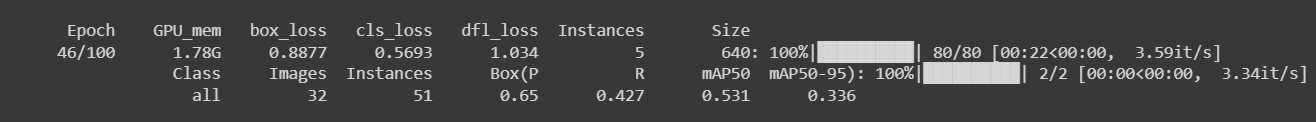

# 3. Осуществим трекинг с помощью детектора YOLOv8 и алгоритмов: ByteTrack, BoT-Sort, Strong-SORT, OC-SORT

# Протестируем модель с применением трекера ByteTrack, встроенным в YOLOv8 на тестовом наборе видео.

In [1]:
!unzip  $data_paths.test_video_path -d $data_paths.dataset_unzip_path

unzip:  cannot find or open .test_video_path, .test_video_path.zip or .test_video_path.ZIP.


In [ ]:
import os


test_videos_dir = os.path.join(data_paths.dataset_unzip_path.join("/test-video/Video"))
video_paths = []
for file_name in os.listdir(test_videos_dir):
  video_paths.append(test_videos_dir, file_name)

# 3.1 ByteTrack

## Работа с данным трекером возможна с помощью библиотеки ultralytics

In [ ]:
trained_detect_model = YOLO(TrainingParams.pretrained_models_weight)

In [ ]:
for file_name in video_paths:
  results = trained_detect_model.track(source=file_name, save=True, tracker="bytetrack.yaml")

# 3.2 BoT-SORT

In [ ]:
for file_name in video_paths:
  results = trained_detect_model.track(source=file_name, save=True, tracker="botsort.yaml")

## Для трекеров, которые не встроены в библиотеке YOLO опишем собственную функцию для осуществления трекинга

In [ ]:
!pip install motmetrics

In [ ]:
!pip install boxmot --quiet

In [ ]:
import numpy as np
from boxmot import StrongSORT
from boxmot.trackers.ocsort.ocsort import OCSort as OCSORT
from pathlib import Path

import cv2
import os

import datetime
import motmetrics as mm

from typing import List, Dict, Tuple

In [ ]:
@dataclass()
class TrackingParams:
    detect_model: YOLO
    tracker: StrongSORT
    vid_path: str
    res_path: str
    colors: Dict[int, Tuple[int, int, int]]
    classes: Dict[int, str]
    thickness: float
    out_path: str

In [16]:
def tracking(tracking_params: TrackingParams):
  vid = cv2.VideoCapture(vid_path)

  fps = vid.get(cv2.CAP_PROP_FPS)
  width = int(vid.get(cv2.CAP_PROP_FRAME_WIDTH))
  height = int(vid.get(cv2.CAP_PROP_FRAME_HEIGHT))

  vid_name = os.path.basename(vid_path)
  out = cv2.VideoWriter(os.path.join(out_path, vid_name), cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))

  out_result = []
  frame_num = 0
  while True:
      start = datetime.datetime.now()

      ret, frame = vid.read()

      if not ret:
          break
      frame_num += 1
      detections = detect_model(frame)
      results = np.array([]).reshape(0, 6)

      for res in detections:
          conf = res.boxes.conf.cpu().numpy()
          class_ids = res.boxes.cls.cpu().numpy()
          boxes = res.boxes.xyxy.cpu().numpy()
          results = np.vstack((results, np.concatenate((boxes, np.round(conf.reshape(-1, 1), 2), class_ids.reshape(-1, 1)), axis=1)))

      if results.shape[0] == 0:
        tracks = np.array([])
      else:
        tracks = tracker.update(results, frame)

      if len(tracks) == 0:
        out_result.append([frame_num, 0, 0, 0, 0, 0, 0])
      else:
        objects = np.repeat(frame_num, tracks.shape[0]).reshape(-1, 1)
        objects = np.concatenate((objects, np.array(tracks[:, 4]).reshape(-1, 1), np.round(np.array(tracks[:, :4]), 2),\
                                  np.round(np.array(tracks[:, 5]).reshape(-1, 1), 2)), axis=1)
        for obj in objects:
          out_result.append(obj)

      if tracks.shape[0] != 0:

          xyxys = tracks[:, 0:4].astype('int')
          ids = tracks[:, 4].astype('int')
          confs = np.round(tracks[:, 5], 2)
          clss = tracks[:, 6].astype('int')
          inds = tracks[:, 7].astype('int')

          for xyxy, id, conf, cls in zip(xyxys, ids, confs, clss):
              color = colors[cls] if cls in colors else (0, 0, 0)
              cls = classes[cls]
              frame = cv2.rectangle(
                  frame,
                  (xyxy[0], xyxy[1]),
                  (xyxy[2], xyxy[3]),
                  color,
                  thickness
              )
              cv2.putText(
                  frame,
                  f'id: {id}, conf: {conf}, c: {cls}',
                  (xyxy[0], xyxy[1]-10),
                  cv2.FONT_HERSHEY_SIMPLEX,
                  fontscale,
                  color,
                  thickness
              )
      out.write(frame)
      end = datetime.datetime.now()
      print(f"Time to process 1 frame: {(end - start).total_seconds() * 1000:.0f} milliseconds")

      fps = f"FPS: {1 / (end - start).total_seconds():.2f}"
      cv2.putText(frame, fps, (50, 50),
                  cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 255), 8)

      out.write(frame)
      if cv2.waitKey(1) == ord("q"):
          break

  vid.release()
  out.release()
  cv2.destroyAllWindows()
  with open(res_path, "w") as file:
    for array in out_result:
      file.write(",".join(map(str, array)) + "\n")

In [ ]:
def motMetricsEnhancedCalculator(gtSource, tSource):
  gt = np.loadtxt(gtSource, delimiter=',')
  t = np.loadtxt(tSource, delimiter=',')
  acc = mm.MOTAccumulator(auto_id=True)

  for frame in range(int(gt[:,0].max())):

    gt_dets = gt[gt[:,0]==frame,1:6]
    t_dets = t[t[:,0]==frame,1:6]

    C = mm.distances.iou_matrix(gt_dets[:,1:], t_dets[:,1:], \
                                max_iou=0.5)


    acc.update(gt_dets[:,0].astype('int').tolist(), \
              t_dets[:,0].astype('int').tolist(), C)

  mh = mm.metrics.create()

  summary = mh.compute(acc, metrics=['num_frames', 'idf1', 'idp', 'idr', \
                                     'recall', 'precision', 'num_objects', \
                                     'mostly_tracked', 'partially_tracked', \
                                     'mostly_lost', 'num_false_positives', \
                                     'num_misses', 'num_switches', \
                                     'num_fragmentations', 'mota', 'motp' \
                                    ], \
                      name='acc')

  strsummary = mm.io.render_summary(
      summary,

      namemap={'idf1': 'IDF1', 'idp': 'IDP', 'idr': 'IDR', 'recall': 'Rcll', \
               'precision': 'Prcn', 'num_objects': 'GT', \
               'mostly_tracked' : 'MT', 'partially_tracked': 'PT', \
               'mostly_lost' : 'ML', 'num_false_positives': 'FP', \
               'num_misses': 'FN', 'num_switches' : 'IDsw', \
               'num_fragmentations' : 'FM', 'mota': 'MOTA', 'motp' : 'MOTP',  \
              }
  )
  print(strsummary)

## Объявим значения переменных для трекинга и визуализации результатов

In [ ]:
colors = {
    0: (255, 0, 0),   # Синий
    1: (0, 255, 0),   # Зеленый
    2: (0, 255, 255), # Желтый
    3: (42, 42, 165), # Коричневый
    4: (0, 0, 255),   # Красный
    5: (128, 0, 128), # Фиолетовый
    6: (0, 0, 0),     # Черный
    7: (128, 128, 128) # Серый
}

classes = {
    0: 'A',
    1: 'B',
    2: 'C',
    3: 'D',
    4: 'E',
    5: 'F',
    6: 'G',
    7: 'H'
}
thickness = 3
fontscale = 1.4
gt_path = '/content/datasets/Test-video/Ground_truth/gt.txt'

# 3. StrongSORT

In [ ]:
!mkdir /content/StrongSORT
out_path = '/content/StrongSORT'
res_path = '/content/StrongSORT/result.txt'


gtSource = '/content/datasets/Test-video/Ground_truth/gt.txt'
tSource = '/content/StrongSORT/result.txt'
tracker = StrongSORT(
  model_weights=Path('osnet_x0_25_market1501.pt'),
  device='cuda',
  fp16=True
)
strong_tracking_params = TrackingParams(
    detect_model=trained_detect_model,
    tracker=tracker,
    vid_path='',
    res_path=res_path
    colors=colors,
    classes=classes,
    thickness=thickness,
    out_path=out_path
)

for vid_path in video_paths:
  strong_tracking_params.vid_path = vid_path
  tracking(strong_tracking_params)
  motMetricsEnhancedCalculator(gtSource, tSource)

# 4. OC-SORT

In [ ]:
!mkdir /content/OC-SORT
out_path = '/content/OC-SORT'
res_path = '/content/OC-SORT/result.txt'

gtSource = '/content/datasets/Test-video/Ground_truth/gt.txt'
tSource = '/content/OC-SORT/result.txt'

tracker = OCSORT()
ocsort_tracking_params = TrackingParams(
    detect_model=trained_detect_model,
    tracker=tracker,
    vid_path='',
    res_path=res_path
    colors=colors,
    classes=classes,
    thickness=thickness,
    out_path=out_path
)
for vid_path in video_paths:
  ocsort_tracking_params.vid_path = vid_path
  tracking(ocsort_tracking_params)
  motMetricsEnhancedCalculator(gtSource, tSource)